This notebook seeks to explore the utility of dimensionality reduction with PCA prior to clustering. At the time of this writing, this notebook considers 3 levels of variance explained: 90%, 95%, and 99%. 
Aside from the reduction we will process the data in the same way as previously done. We will scale the data using sklearn's standardScaler and cluster the data using the method clusterOutliers.db_out.
We will compare these reductions to the clustering done on the 

In [88]:
# Some standard imports for math and data handling
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from scipy import stats

# Imports for processing specific to this workbook
from sklearn.decomposition import PCA
from sklearn import preprocessing
from datetime import datetime

# Import the custom code developed for this work
import sys
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo

In [50]:
def import_quarter(QN='Q4'):
    # Import the dataframe containing the data
    featCSV = "/home/dgiles/Documents/KeplerLCs/output/"+QN+"_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
    fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles" # path to fits files folder
    return coo(featCSV,fitsDir)

Q4 = import_quarter('Q4')
Q8 = import_quarter('Q8')
Q11 = import_quarter('Q11')
Q16 = import_quarter('Q16')

In [4]:
# Check what's in the data
print(Q4.data.columns[60:])

Index(['db_out', 'pca_x', 'pca_y', 'db_cluster', 'exc_labels'], dtype='object')


* db_out - cluster designation made earlier by this work (based on DBSCAN, but focused on outliers. Only has 3 designations.)
* pca_x - 1st dimension of a 2D PCA reduction
* pca_y - 2nd dimension of a 2D PCA reduction
* db_cluster - Actual DBSCAN cluster identifier
* exc_labels - Labels for each object as to whether they are outliers in a single quarter, multiple quarters, or all quarters. 

In [46]:
def dataScaler(qdf):
    """
    Data scaler for this work, returns a dataframe w/ scaled features
    """
    data = qdf.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(index=qdf.index,\
                             columns=qdf.columns[:60],\
                             data=scaled_data)
    return scaled_df

In [47]:
def pca_red(data,scaled=False,var_rat=0.9):
    """
    Returns a pca reduction of the given data that explains a
    given fraction of the variance.
    Args:
        data (pandas dataframe) - the data to be reduced
        var_rat (float between 0 and 1) - the ratio of variance to be 
            explained by the transformed data
            
    Returns:
        reduced_data - numpy array of reduced data
        prints the number of dimensions and the explained variance
    """
    if scaled:
        scaled_data = data
    else:
        print("Scaling data using StandardScaler...")
        scaled_data = dataScaler(data)

    print("Finding minimum number of dimensions to explain {:04.1f}% of the variance...".format(var_rat*100))
    
    for i in range(60):
        pca = PCA(n_components=i)
        pca.fit(scaled_data)
        if sum(pca.explained_variance_ratio_) >= var_rat:
            break
    print("""
    Dimensions: {:d},
    Variance explained: {:04.1f}%
    """.format(i,sum(pca.explained_variance_ratio_)*100))
    reduced_data = pd.DataFrame(index=data.index, \
                                data=pca.transform(scaled_data))
    return reduced_data


# Reductions and Clustering

## Quarter 4

In [97]:
# Only want to scale the feature data generated by keplerml.py
data_tbs = Q4.data.iloc[:,0:60]
reds = dict()
for i,vr in enumerate([0.9,0.95,0.99]):
    print("PCA Reduction explaining {:02.0f}% of the variance:".format(vr*100))
    start = datetime.now()
    reds[i] = pca_red(data_tbs, var_rat=vr)
    print("Time to reduce: {}".format(datetime.now()-start))
    print("")

PCA Reduction explaining 90% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 90.0% of the variance...

    Dimensions: 18,
    Variance explained: 90.5%
    
Time to reduce: 0:00:13.124157
PCA Reduction explaining 95% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 95.0% of the variance...

    Dimensions: 23,
    Variance explained: 95.1%
    
Time to reduce: 0:00:19.107702
PCA Reduction explaining 99% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 99.0% of the variance...

    Dimensions: 35,
    Variance explained: 99.1%
    
Time to reduce: 0:00:39.758400


In [102]:
for k in reds:
    start = datetime.now()
    out_labels = Q4.db_out(df=reds[k])
    reds[k]['db_out']=out_labels
    print("Time to cluster: {}".format(datetime.now()-start))

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.04.
        
Scaling density...
Clustering data with DBSCAN, eps=04.04,min_samples=59.9156...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
python/db_outliers.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  distArr = distances[:,min_n]    #this should be calculated before eps_est and fed in, it's


There were 2 clusters and 3216 total outliers
Time to cluster: 0:05:05.053670
Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 03.83.
        
Scaling density...
Clustering data with DBSCAN, eps=03.83,min_samples=59.9156...
There were 2 clusters and 4203 total outliers
Time to cluster: 0:05:09.315667
Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 05.13.
        
Scaling density...
Clustering data with DBSCAN, eps=05.13,min_samples=59.9156...
There were 2 clusters and 3203 total outliers
Time to cluster: 0:07:33.823373


In [105]:
PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"

In [104]:
reds[0].to_csv(PCA_folder+"Q4_PCA90")
reds[1].to_csv(PCA_folder+"Q4_PCA95")
reds[2].to_csv(PCA_folder+"Q4_PCA99")

In [109]:
QN="Q4"
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles"
Q4_pca90 = coo(feats=PCA_folder+QN+"_PCA90",fitsDir=fitsDir)
Q4_pca95 = coo(feats=PCA_folder+QN+"_PCA95",fitsDir=fitsDir)
Q4_pca99 = coo(feats=PCA_folder+QN+"_PCA99",fitsDir=fitsDir)

## Quarter 8

In [111]:
# Only want to scale the feature data generated by keplerml.py
data_tbs = Q8.data.iloc[:,0:60]
reds = dict()
for i,vr in enumerate([0.9,0.95,0.99]):
    print("PCA Reduction explaining {:02.0f}% of the variance:".format(vr*100))
    rstart = datetime.now()
    reds[i] = pca_red(data_tbs, var_rat=vr)
    print("Time to reduce: {}".format(datetime.now()-rstart))
    print("")
    cstart = datetime.now()
    # it doesn't matter which cluster object calls the 
    # method since the data frame to be processed is provided explicitly
    out_labels = Q4.db_out(df=reds[i]) 
    reds[i]['db_out']=out_labels
    print("""Time to cluster: {}
    Total time to process: {}""".format(datetime.now()-cstart,datetime.now()-rstart))
    print("")

PCA Reduction explaining 90% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 90.0% of the variance...

    Dimensions: 18,
    Variance explained: 90.7%
    
Time to reduce: 0:00:14.487903

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.07.
        
Scaling density...
Clustering data with DBSCAN, eps=04.07,min_samples=59.9156...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
python/db_outliers.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  distArr = distances[:,min_n]    #this should be calculated before eps_est and fed in, it's


There were 2 clusters and 3475 total outliers
Time to cluster: 0:05:40.626828
    Total time to process: 0:05:55.115283

PCA Reduction explaining 95% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 95.0% of the variance...

    Dimensions: 24,
    Variance explained: 95.4%
    
Time to reduce: 0:00:21.812244

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.46.
        
Scaling density...
Clustering data with DBSCAN, eps=04.46,min_samples=59.9156...
There were 2 clusters and 3658 total outliers
Time to cluster: 0:06:48.035085
    Total time to process: 0:07:09.847866

PCA Reduction explaining 99% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 99.0% of the variance...

    Dimensions: 36,
    Variance explained: 99.1%
    
Time to reduce: 0:00:40.486147

Esti

In [112]:
reds[0].to_csv(PCA_folder+"Q8_PCA90")
reds[1].to_csv(PCA_folder+"Q8_PCA95")
reds[2].to_csv(PCA_folder+"Q8_PCA99")

In [113]:
QN="Q8"
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles"
Q8_pca90 = coo(feats=PCA_folder+QN+"_PCA90",fitsDir=fitsDir)
Q8_pca95 = coo(feats=PCA_folder+QN+"_PCA95",fitsDir=fitsDir)
Q8_pca99 = coo(feats=PCA_folder+QN+"_PCA99",fitsDir=fitsDir)

## Quarter 11

In [114]:
# Only want to scale the feature data generated by keplerml.py
data_tbs = Q11.data.iloc[:,0:60]
reds = dict()
for i,vr in enumerate([0.9,0.95,0.99]):
    print("PCA Reduction explaining {:02.0f}% of the variance:".format(vr*100))
    rstart = datetime.now()
    reds[i] = pca_red(data_tbs, var_rat=vr)
    print("Time to reduce: {}".format(datetime.now()-rstart))
    print("")
    cstart = datetime.now()
    # it doesn't matter which cluster object calls the 
    # method since the data frame to be processed is provided explicitly
    out_labels = Q4.db_out(df=reds[i]) 
    reds[i]['db_out']=out_labels
    print("""Time to cluster: {}
    Total time to process: {}""".format(datetime.now()-cstart,datetime.now()-rstart))
    print("")

PCA Reduction explaining 90% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 90.0% of the variance...

    Dimensions: 17,
    Variance explained: 90.8%
    
Time to reduce: 0:00:13.315329

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 03.14.
        
Scaling density...
Clustering data with DBSCAN, eps=03.14,min_samples=59.9156...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
python/db_outliers.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  distArr = distances[:,min_n]    #this should be calculated before eps_est and fed in, it's


There were 2 clusters and 4712 total outliers
Time to cluster: 0:05:45.844997
    Total time to process: 0:05:59.160851

PCA Reduction explaining 95% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 95.0% of the variance...

    Dimensions: 22,
    Variance explained: 95.1%
    
Time to reduce: 0:00:19.301998

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.63.
        
Scaling density...
Clustering data with DBSCAN, eps=04.63,min_samples=59.9156...
There were 2 clusters and 3217 total outliers
Time to cluster: 0:06:34.340393
    Total time to process: 0:06:53.643074

PCA Reduction explaining 99% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 99.0% of the variance...

    Dimensions: 34,
    Variance explained: 99.1%
    
Time to reduce: 0:00:38.415011

Esti

In [115]:
reds[0].to_csv(PCA_folder+"Q11_PCA90")
reds[1].to_csv(PCA_folder+"Q11_PCA95")
reds[2].to_csv(PCA_folder+"Q11_PCA99")

In [116]:
QN="Q11"
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles"
Q11_pca90 = coo(feats=PCA_folder+QN+"_PCA90",fitsDir=fitsDir)
Q11_pca95 = coo(feats=PCA_folder+QN+"_PCA95",fitsDir=fitsDir)
Q11_pca99 = coo(feats=PCA_folder+QN+"_PCA99",fitsDir=fitsDir)

## Quarter 16

In [117]:
# Only want to scale the feature data generated by keplerml.py
data_tbs = Q16.data.iloc[:,0:60]
reds = dict()
for i,vr in enumerate([0.9,0.95,0.99]):
    print("PCA Reduction explaining {:02.0f}% of the variance:".format(vr*100))
    rstart = datetime.now()
    reds[i] = pca_red(data_tbs, var_rat=vr)
    print("Time to reduce: {}".format(datetime.now()-rstart))
    print("")
    cstart = datetime.now()
    # it doesn't matter which cluster object calls the 
    # method since the data frame to be processed is provided explicitly
    out_labels = Q4.db_out(df=reds[i]) 
    reds[i]['db_out']=out_labels
    print("""Time to cluster: {}
    Total time to process: {}""".format(datetime.now()-cstart,datetime.now()-rstart))
    print("")

PCA Reduction explaining 90% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 90.0% of the variance...

    Dimensions: 17,
    Variance explained: 90.1%
    
Time to reduce: 0:00:13.144180

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 03.92.
        
Scaling density...
Clustering data with DBSCAN, eps=03.92,min_samples=59.9156...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
python/db_outliers.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  distArr = distances[:,min_n]    #this should be calculated before eps_est and fed in, it's


There were 2 clusters and 3526 total outliers
Time to cluster: 0:06:31.139474
    Total time to process: 0:06:44.284192

PCA Reduction explaining 95% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 95.0% of the variance...

    Dimensions: 23,
    Variance explained: 95.6%
    
Time to reduce: 0:00:21.149542

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 04.50.
        
Scaling density...
Clustering data with DBSCAN, eps=04.50,min_samples=59.9156...
There were 2 clusters and 3484 total outliers
Time to cluster: 0:06:04.522204
    Total time to process: 0:06:25.672290

PCA Reduction explaining 99% of the variance:
Scaling data using StandardScaler...
Finding minimum number of dimensions to explain 99.0% of the variance...

    Dimensions: 34,
    Variance explained: 99.0%
    
Time to reduce: 0:00:36.888205

Esti

In [118]:
reds[0].to_csv(PCA_folder+"Q16_PCA90")
reds[1].to_csv(PCA_folder+"Q16_PCA95")
reds[2].to_csv(PCA_folder+"Q16_PCA99")

In [119]:
QN="Q16"
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles"
Q16_pca90 = coo(feats=PCA_folder+QN+"_PCA90",fitsDir=fitsDir)
Q16_pca95 = coo(feats=PCA_folder+QN+"_PCA95",fitsDir=fitsDir)
Q16_pca99 = coo(feats=PCA_folder+QN+"_PCA99",fitsDir=fitsDir)

## Baselines

In [49]:
start = datetime.now()
scaled_data = dataScaler(Q4.data)
Q4_base = Q4.db_out(df=scaled_data)
print("Time to cluster: {}".format(datetime.now()-start))

Estimating Parameters...
Sampling data for parameter estimation...
Calculating nearest neighbor distances...
Finding elbow...

        Epsilon is in the neighborhood of 05.36.
        
Scaling density...
Clustering data with DBSCAN, eps=05.36,min_samples=59.9156...


/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
python/db_outliers.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  distArr = distances[:,min_n]    #this should be calculated before eps_est and fed in, it's


There were 2 clusters and 3098 total outliers
Time to cluster: 0:13:06.068176


In [ ]:
"""
This cell did run, but connectivity issues messed up the output. 
Not sure what to do about that... The details of the clustering are lost.
Might rerun it so that the output is explicitly included (looking back at past code
has been a pain since I didn't save the output and have lost the calculated
parameters in the process for past work.)
"""
print("Quarter 8 baseline")
start = datetime.now()
scaled_data = dataScaler(Q8.data)
Q8_base = Q8.db_out(df=scaled_data)
print("Time to cluster: {}".format(datetime.now()-start))

print("Quarter 11 baseline")
start = datetime.now()
scaled_data = dataScaler(Q11.data)
Q11_base = Q11.db_out(df=scaled_data)
print("Time to cluster: {}".format(datetime.now()-start))

print("Quarter 16 baseline")
start = datetime.now()
scaled_data = dataScaler(Q16.data)
Q16_base = Q16.db_out(df=scaled_data)
print("Time to cluster: {}".format(datetime.now()-start))

Quarter 8 baseline


In [59]:
print("""
Q4 Total Outliers: {:d}
Q8 Total Outliers: {:d}
Q11 Total Outliers: {:d}
Q16 Total Outliers: {:d}
""".format(len(Q4_base[Q4_base==-1]),
           len(Q8_base[Q8_base==-1]),
           len(Q11_base[Q11_base==-1]),
           len(Q16_base[Q16_base==-1])
          )
     )


Q4 Total Outliers: 3098
Q8 Total Outliers: 4123
Q11 Total Outliers: 3151
Q16 Total Outliers: 4796



In [124]:
# The clusterOutlier objects bring in previously calculated cluster designations
# We have redone the clustering here in the interest of ensuring we apply
# the same methodology throughout.
# So we store the newly produced cluster output in 'b' versions.
# I don't know if this is working the way I intend it to...
Q4b = Q4
Q4b.data['db_out']=Q4_base
Q8b = Q8
Q8b.data['db_out']=Q8_base
Q11b = Q11
Q11b.data['db_out']=Q11_base
Q16b = Q16
Q16b.data['db_out']=Q16_base

In [200]:
Q4.data.to_csv(PCA_folder+"Q4_base")
Q8.data.to_csv(PCA_folder+"Q8_base")
Q11.data.to_csv(PCA_folder+"Q11_base")
Q16.data.to_csv(PCA_folder+"Q16_base")

# Outlier Population Comparisons

## Outliers In Common

In [163]:
kid_out = lambda q: q.data.index[q.data.db_out==-1]
kid_edge = lambda q: q.data.index[q.data.db_out==1]

In [164]:
Q4a = import_quarter('Q4')
Q8a = import_quarter('Q8')
Q11a = import_quarter('Q11')
Q16a = import_quarter('Q16')

In [183]:
def cluster_comparison(qd1,qd2):
    """
    Comparing populations of outliers from quarter data 1 to quarter data 2
    """
    
    # outliers
    qd1_outs = kid_out(qd1)
    qd2_outs = kid_out(qd2)
    outs_comm = np.intersect1d(qd1_outs,qd2_outs)
    print("""
    Outliers in first set:  {:d}
    Outliers in second set: {:d}
    Outliers in common:     {:d}""".format(len(qd1_outs),len(qd2_outs),len(outs_comm)))    
    
    # edges and outliers
    # Not doing edge-only overlap because it's a smaller population
    # and I don't think it's as informative as the combined overlap.
    qd1_edges = kid_edge(qd1)
    qd1_not_core = np.append(qd1_outs,qd1_edges)
    qd2_edges = kid_edge(qd2)
    qd2_not_core = np.append(qd2_outs,qd2_edges)
    not_core_comm = np.intersect1d(qd1_not_core,qd2_not_core)
    print("""
    Non-core first set:  {:d}
    Non-core second set: {:d}
    Non-core overlap:    {:d}
    """.format(len(qd1_not_core),len(qd2_not_core),len(not_core_comm)))

In [194]:
print("Quarter 4")
print("Paper to Baseline")
cluster_comparison(Q4a,Q4)
print("Paper to PCA 90")
cluster_comparison(Q4a,Q4_pca90)
print("Paper to PCA 95")
cluster_comparison(Q4a,Q4_pca95)
print("Paper to PCA 99")
cluster_comparison(Q4a,Q4_pca99)
print("Baseline to PCA 90")
cluster_comparison(Q4,Q4_pca90)
print("Baseline to PCA 95")
cluster_comparison(Q4,Q4_pca95)
print("Baseline to PCA 99")
cluster_comparison(Q4,Q4_pca99)
print("90 to 95")
cluster_comparison(Q4_pca90,Q4_pca95)
print("90 to 99")
cluster_comparison(Q4_pca90,Q4_pca99)
print("95 to 99")
cluster_comparison(Q4_pca95,Q4_pca99)

Quarter 4
Paper to Baseline

    Outliers in first set:  4866
    Outliers in second set: 3098
    Outliers in common:     3098

    Non-core first set:  7255
    Non-core second set: 4679
    Non-core overlap:    4679
    
Paper to PCA 90

    Outliers in first set:  4866
    Outliers in second set: 3216
    Outliers in common:     3216

    Non-core first set:  7255
    Non-core second set: 4848
    Non-core overlap:    4848
    
Paper to PCA 95

    Outliers in first set:  4866
    Outliers in second set: 4203
    Outliers in common:     4200

    Non-core first set:  7255
    Non-core second set: 6225
    Non-core overlap:    6219
    
Paper to PCA 99

    Outliers in first set:  4866
    Outliers in second set: 3203
    Outliers in common:     3203

    Non-core first set:  7255
    Non-core second set: 4809
    Non-core overlap:    4809
    
Baseline to PCA 90

    Outliers in first set:  3098
    Outliers in second set: 3216
    Outliers in common:     2958

    Non-core first s

In [195]:
print("Quarter 8")
print("Paper to Baseline")
cluster_comparison(Q8a,Q8)
print("Paper to PCA 90")
cluster_comparison(Q8a,Q8_pca90)
print("Paper to PCA 95")
cluster_comparison(Q8a,Q8_pca95)
print("Paper to PCA 99")
cluster_comparison(Q8a,Q8_pca99)
print("Baseline to PCA 90")
cluster_comparison(Q8,Q8_pca90)
print("Baseline to PCA 95")
cluster_comparison(Q8,Q8_pca95)
print("Baseline to PCA 99")
cluster_comparison(Q8,Q8_pca99)
print("90 to 95")
cluster_comparison(Q8_pca90,Q8_pca95)
print("90 to 99")
cluster_comparison(Q8_pca90,Q8_pca99)
print("95 to 99")
cluster_comparison(Q8_pca95,Q8_pca99)

Quarter 8
Paper to Baseline

    Outliers in first set:  5044
    Outliers in second set: 4123
    Outliers in common:     4123

    Non-core first set:  7554
    Non-core second set: 6053
    Non-core overlap:    6053
    
Paper to PCA 90

    Outliers in first set:  5044
    Outliers in second set: 3475
    Outliers in common:     3475

    Non-core first set:  7554
    Non-core second set: 5125
    Non-core overlap:    5125
    
Paper to PCA 95

    Outliers in first set:  5044
    Outliers in second set: 3658
    Outliers in common:     3658

    Non-core first set:  7554
    Non-core second set: 5450
    Non-core overlap:    5450
    
Paper to PCA 99

    Outliers in first set:  5044
    Outliers in second set: 3327
    Outliers in common:     3327

    Non-core first set:  7554
    Non-core second set: 4924
    Non-core overlap:    4924
    
Baseline to PCA 90

    Outliers in first set:  4123
    Outliers in second set: 3475
    Outliers in common:     3452

    Non-core first s

In [196]:
print("Quarter 8")
print("Paper to Baseline")
cluster_comparison(Q8a,Q8)
print("Paper to PCA 90")
cluster_comparison(Q8a,Q8_pca90)
print("Paper to PCA 95")
cluster_comparison(Q8a,Q8_pca95)
print("Paper to PCA 99")
cluster_comparison(Q8a,Q8_pca99)
print("Baseline to PCA 90")
cluster_comparison(Q8,Q8_pca90)
print("Baseline to PCA 95")
cluster_comparison(Q8,Q8_pca95)
print("Baseline to PCA 99")
cluster_comparison(Q8,Q8_pca99)
print("90 to 95")
cluster_comparison(Q8_pca90,Q8_pca95)
print("90 to 99")
cluster_comparison(Q8_pca90,Q8_pca99)
print("95 to 99")
cluster_comparison(Q8_pca95,Q8_pca99)

Quarter 8
Paper to Baseline

    Outliers in first set:  5044
    Outliers in second set: 4123
    Outliers in common:     4123

    Non-core first set:  7554
    Non-core second set: 6053
    Non-core overlap:    6053
    
Paper to PCA 90

    Outliers in first set:  5044
    Outliers in second set: 3475
    Outliers in common:     3475

    Non-core first set:  7554
    Non-core second set: 5125
    Non-core overlap:    5125
    
Paper to PCA 95

    Outliers in first set:  5044
    Outliers in second set: 3658
    Outliers in common:     3658

    Non-core first set:  7554
    Non-core second set: 5450
    Non-core overlap:    5450
    
Paper to PCA 99

    Outliers in first set:  5044
    Outliers in second set: 3327
    Outliers in common:     3327

    Non-core first set:  7554
    Non-core second set: 4924
    Non-core overlap:    4924
    
Baseline to PCA 90

    Outliers in first set:  4123
    Outliers in second set: 3475
    Outliers in common:     3452

    Non-core first s

In [198]:
print("Quarter 11")
print("Paper to Baseline")
cluster_comparison(Q11a,Q11)
print("Paper to PCA 90")
cluster_comparison(Q11a,Q11_pca90)
print("Paper to PCA 95")
cluster_comparison(Q11a,Q11_pca95)
print("Paper to PCA 99")
cluster_comparison(Q11a,Q11_pca99)
print("Baseline to PCA 90")
cluster_comparison(Q11,Q11_pca90)
print("Baseline to PCA 95")
cluster_comparison(Q11,Q11_pca95)
print("Baseline to PCA 99")
cluster_comparison(Q11,Q11_pca99)
print("90 to 95")
cluster_comparison(Q11_pca90,Q11_pca95)
print("90 to 99")
cluster_comparison(Q11_pca90,Q11_pca99)
print("95 to 99")
cluster_comparison(Q11_pca95,Q11_pca99)

Quarter 11
Paper to Baseline

    Outliers in first set:  5879
    Outliers in second set: 3151
    Outliers in common:     3151

    Non-core first set:  8856
    Non-core second set: 4845
    Non-core overlap:    4845
    
Paper to PCA 90

    Outliers in first set:  5879
    Outliers in second set: 4712
    Outliers in common:     4705

    Non-core first set:  8856
    Non-core second set: 6860
    Non-core overlap:    6844
    
Paper to PCA 95

    Outliers in first set:  5879
    Outliers in second set: 3217
    Outliers in common:     3217

    Non-core first set:  8856
    Non-core second set: 4933
    Non-core overlap:    4933
    
Paper to PCA 99

    Outliers in first set:  5879
    Outliers in second set: 3074
    Outliers in common:     3074

    Non-core first set:  8856
    Non-core second set: 4736
    Non-core overlap:    4736
    
Baseline to PCA 90

    Outliers in first set:  3151
    Outliers in second set: 4712
    Outliers in common:     3140

    Non-core first 

In [199]:
print("Quarter 16")
print("Paper to Baseline")
cluster_comparison(Q16a,Q16)
print("Paper to PCA 90")
cluster_comparison(Q16a,Q16_pca90)
print("Paper to PCA 95")
cluster_comparison(Q16a,Q16_pca95)
print("Paper to PCA 99")
cluster_comparison(Q16a,Q16_pca99)
print("Baseline to PCA 90")
cluster_comparison(Q16,Q16_pca90)
print("Baseline to PCA 95")
cluster_comparison(Q16,Q16_pca95)
print("Baseline to PCA 99")
cluster_comparison(Q16,Q16_pca99)
print("90 to 95")
cluster_comparison(Q16_pca90,Q16_pca95)
print("90 to 99")
cluster_comparison(Q16_pca90,Q16_pca99)
print("95 to 99")
cluster_comparison(Q16_pca95,Q16_pca99)

Quarter 16
Paper to Baseline

    Outliers in first set:  5750
    Outliers in second set: 4796
    Outliers in common:     4796

    Non-core first set:  8660
    Non-core second set: 6989
    Non-core overlap:    6989
    
Paper to PCA 90

    Outliers in first set:  5750
    Outliers in second set: 3526
    Outliers in common:     3526

    Non-core first set:  8660
    Non-core second set: 5195
    Non-core overlap:    5195
    
Paper to PCA 95

    Outliers in first set:  5750
    Outliers in second set: 3484
    Outliers in common:     3484

    Non-core first set:  8660
    Non-core second set: 5204
    Non-core overlap:    5204
    
Paper to PCA 99

    Outliers in first set:  5750
    Outliers in second set: 4037
    Outliers in common:     4037

    Non-core first set:  8660
    Non-core second set: 5926
    Non-core overlap:    5926
    
Baseline to PCA 90

    Outliers in first set:  4796
    Outliers in second set: 3526
    Outliers in common:     3526

    Non-core first 

## Some plots

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [203]:
Q4_pca90.data[Q4_pca90.data.columns[:5]][:10]

,0,1,2,3,4
KID,,,,,
kplr000757076,-0.506421,-0.434655,-0.167335,-0.653499,1.755279
kplr000757099,4.484396,-0.604195,1.211985,-4.750476,-2.081261
kplr000757137,0.920785,-3.099399,0.623951,-2.486847,-2.150655
kplr000757280,0.139649,-2.545948,0.364790,-0.499807,0.013925
kplr000757450,1.470896,-2.336332,0.516864,0.586687,-0.658776
kplr000891901,-0.620495,-0.222029,-0.081033,0.249993,1.040637
kplr000891916,1.590050,-4.515782,1.260458,0.351274,-1.284734
kplr000892107,-0.504158,-0.360687,-0.112151,-0.705359,1.315910
kplr000892195,-0.774194,1.081286,-0.064552,0.511291,-0.390051


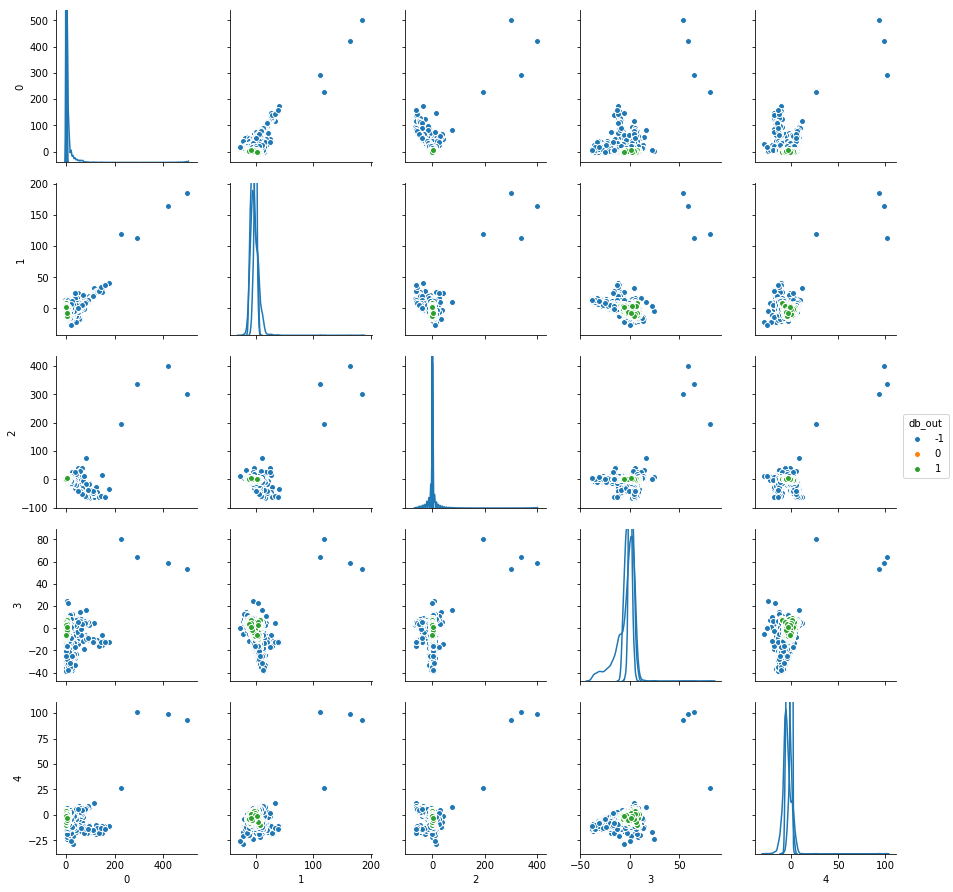

In [213]:
sns.pairplot(Q4_pca90.data,vars=['0','1','2','3','4'],hue='db_out',diag_kind='kde')

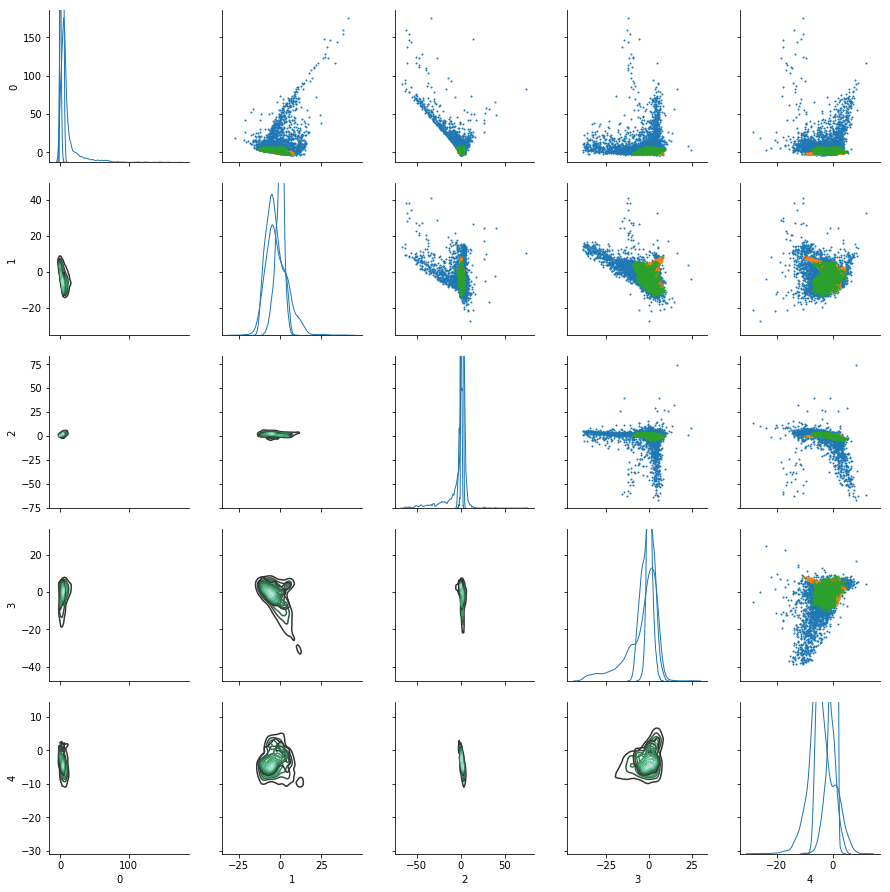

In [215]:
PG = sns.PairGrid(Q4_pca90.data[Q4_pca90.data['1']<75],vars=['0','1','2','3','4'],hue='db_out')
PG.map_lower(sns.kdeplot)
PG.map_upper(plt.scatter, edgecolor=None,s=1)
PG.map_diag(sns.kdeplot, lw=1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data = Q4_pca90.data[Q4_pca90.data.db_out==0]
xs = data['1']
ys = data['2']
zs = data['3']
#cs = Q4_pca90.data['db_out']
ax.scatter(xs, ys, zs,c=cs)


ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py", line 141, in to_rgba
    rgba = _colors_full_map.cache[c, alpha]
TypeError: unhashable type: 'numpy.ndarray'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    hand